# Descrição de Atividade

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
 2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
 3. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
 4. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
 5. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
 6. Experimente outras estratégias de ensembles (e.g. Stacking).
 7. Experimente balancear as classes,  caso estejam desbalanceadas.

Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data (Links para um site externo)Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.


### Descrição dos dados:

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

* **ano**: Ano da eleição;
* **sequencial_candidato**: O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
* **nome**: Nome do candidato;
* **uf**: Sigla do estado do candidato;
* **partido**: Partido do candidato;
* **quantidade_doacoes**: Número de doações que um candidato recebeu;
* **quantidade_doadores**: Numero de doadores que um candidato teve;
* **total_receita**: Total de receita de um candidato;
* **media_receita**: Média da receita de um candidato;
* **recursos_de_outros_candidatos.comites**: Total de receita proveniente de outros candidatos e comitês;
* **recursos_de_pessoas_fisicas**: Total de receita proveniente de pessoas físicas;
* **recursos_de_pessoas_juridicas**: Total de receita proveniente de pessoas juridicas;
* **recursos_proprios**:Total de receita proveniente dos próprios candidatos;
* **recursos_de_partido_politico**: Total de receita proveniente do partido do candidato;
* **quantidade_despesas**: Número de despesas que um candidato teve;
* **quantidade_fornecedores**: Número de fornecedores que um candidato teve;
* **total_despesa**: Total de depesa de um candidato;
* **media_despesa**: Média da despesa de um candidato;
* **cargo**: Cargo ao qual o candidato está concorrendo;
* **sexo**: Sexo do candidato;
* **grau**: Grau de escolaridade do candidato;
* **estado_civil**: Estado civil do candidato;
* **ocupacao**: Ocupação do candidato;
* **situacao**: Situação final do candidato. Corresponde à coluna **Predict** do arquivo de submissão;

## Import Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

sns.set(style="ticks")

%matplotlib inline

## Load Data

In [26]:
train_df = pd.read_csv('../data/assignment_4/train.csv')
test_df = pd.read_csv('../data/assignment_4/test.csv')

data = pd.concat([train_df, test_df], sort=False)

data.set_index('sequencial_candidato', inplace=True, drop=True)

## Preprocess Data

In [27]:
qt = QuantileTransformer(random_state=2, output_distribution='normal')

skewed_features = ['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos.comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'recursos_de_partido_politico',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa']

data[skewed_features] = qt.fit_transform(X=data[skewed_features])

In [28]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

data.replace(cleanup_nums, inplace=True)
data["grau"] = pd.to_numeric(data["grau"])

In [29]:
categorical_feats = [col for col in data.columns if not np.issubdtype(data[str(col)].dtype, np.number) and col not in ['nome', 'situacao']]

data = pd.get_dummies(data, columns=categorical_feats)
data.shape

(12214, 259)

## Split Data into Train and Test

In [34]:
train = data[(data.ano == 2006) | (data.ano == 2010)]
test = data[data.ano == 2014]

print(train.shape)
print(test.shape)

(7622, 259)
(4592, 259)


## Target Class Unbalancing

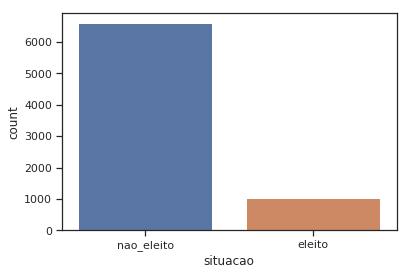

In [35]:
sns.countplot(x='situacao', data=train)

In [37]:
num_elected_candidates = train.situacao[train.situacao == 'eleito'].count()
num_not_elected_candidates = train.situacao[train.situacao == 'nao_eleito'].count()
total_candidates = train.shape[0]

print("Número de candidatos Eleitos: {}".format(num_elected_candidates))
print("Número de candidatos Não-Eleitos: {}".format(num_not_elected_candidates))
print("Total de candidatos: {}\n".format(total_candidates))

print("Proporção de candidatos eleitos: {:2.2%}".format((num_elected_candidates/total_candidates)))
print("Proporção de candidatos não-eleitos: {:2.2%}".format((num_not_elected_candidates/total_candidates)))

Número de candidatos Eleitos: 1026
Número de candidatos Não-Eleitos: 6596
Total de candidatos: 7622

Proporção de candidatos eleitos: 13.46%
Proporção de candidatos não-eleitos: 86.54%


A variável alvo **situacao** é bastante _desbalanceada_, em uma proporção de aproximadamente 1 eleito para cada 6 não-eleitos. Precisamente 13.46% dos candidatos foram eleitos, enquanto 86.54% não foram eleitos.

Esse desbalanceamento pode causar alguns efeitos colaterais na classificação feita pelo modelo preditor, tais como overfitting do modelo em relação à classe majoritária, o que prejudica a acurácia da predição, podendo causar até mesmo a interpretação incorreta dos resultados se o desbalanceamento não for endereçado corretamente.

Existem algumas práticas que podemos adotar para corrigir e lidar com esse desbalanceamento, a saber:

* Coleta de mais dados, que poderia rebalancear as classes, a depender da natureza do problema;
* Mudar a forma de amostragem do dataset, a qual pode estar gerando uma amostra desbalanceada, contudo o dataset não está desbalanceado;
* Usar alguma forma de gerar dados sintéticos como Synthetic Minority Over-sampling Technique [SMOTE](https://imbalanced-learn.org/en/stable/over_sampling.html#cbhk2002) e Adaptive Synthetic [ADASYN](https://imbalanced-learn.org/en/stable/over_sampling.html#hbgl2008);
* Incorporar algum modelo que tem uma forma de penalização para compensar o desbalanceamento de classes a exemplo de penalized-LDA e penalized-SVM;

## Modelos - Versão 1

Nesta versão, utilizamos como dados de treino, os dados da eleição de 2006, e como dados de teste, os dados da eleição de 2010. Em um segundo momento, utilizaremos os dados da eleição de 2014 como dados de teste.

In [ ]:
candidates_train = candidates_df[candidates_df.ano == 2006]
candidates_val = candidates_df[candidates_df.ano == 2010]

feats = candidates_df.columns[candidates_df.columns != 'votos']

X_train = candidates_train[feats]
y_train = candidates_train['votos']

X_val = candidates_val[feats]
y_val = candidates_val['votos']

### Validação Cruzada

Abaixo definimos uma adaptação de uma função criada por Alexandru Papiu em [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models), que nos retorna a média dos RMSE's de um dado modelo para uma cross-validation no dataset de treino e um k-fold com k = 5.

In [ ]:
def mean_rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)).mean()

### Sem Regularização


In [ ]:
lr = LinearRegression().fit(X_train, y_train)
predictions = lr.predict(X_val)

print("RMSE Linear Regressor - Train - Cross-Validated: {:2.3}".format(mean_rmse_cv(lr)))
print("RMSE Linear Regressor - Validation: {:2.3}".format(np.sqrt(mean_squared_error(y_pred=predictions, y_true=y_val))))

Como podemos observar, os valores de RMSE para um modelo linear multivariado sem regularização tem um erro bastante elevado. Isso provavelmente se deve ao fato de está acontecendo overfitting. Uma simples olhada na ordem dos coeficientes do modelo nos permite observar isso. Caso os coeficientes sejam muito grandes, temos overfitting.

In [ ]:
coefs = lr.coef_
ax = sns.distplot(coefs, kde=False)
ax.set(xlabel='Valores dos Coeficientes', ylabel='Quantidade de Coeficientes')
plt.show()

##### **Plot Resíduos vs Predições - Linear Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_val, predictions)

Como vemos, nosso modelo feito com um Linear Regressor sem regularização não é um bom preditor: nós não observamos padrões visuais surgindo na distribuição dos resíduos, o que é um mal indício de adequabilidade do modelo, existem características que não estão sendo corretamente capturadas. E também os pontos estão concentrados aleatoriamente ao redor da linha nula (0).

### Com Regularização

#### **_Ridge_**

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

ridge_train_rmses = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    ridge_train_rmses.append(mean_rmse_cv(ridge))

cv_ridge_train = pd.Series(ridge_train_rmses, index = alphas)

cv_ridge_train.plot(title = "Training Data")
plt.xlabel("alpha")
plt.ylabel("rmse")

O valor de **alpha** associado com o menor RMSE é **10**. Então vamos utilizar esse valor para configurar nosso modelo de regressão linear Ridge, o qual utiliza normalização **l2**. O valor de RMSE encontrado para alpha = 10 é em torno de 1.02.

In [ ]:
cv_ridge_train.min()

In [ ]:
ridge = Ridge(alpha = 10).fit(X_train, y_train)
predictions = ridge.predict(X_val)
print("RMSE Ridge Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(ridge)))
print("RMSE Ridge Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

##### **Plot Resíduos vs Predições - Ridge**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Ridge é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

#### **_Lasso_**

In [ ]:
model_lasso = LassoCV(alphas = [1, 5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6], max_iter=1e5).fit(X_train, y_train)
predictions = model_lasso.predict(X_val)
print("RMSE Lasso Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(model_lasso)))
print("RMSE Lasso Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

O modelo Ridge se sai um pouco melhor que o modelo Lasso. Complementando a análise, podemos identificar quais variáveis foram consideradas ou eliminadas pelo modelo de regressão Lasso.

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

##### **Plot Resíduos vs Predições - Lasso**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
predictions = model_lasso.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Lasso é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

### Non-Parameterized Models

#### **_KNN (K-Nearest Neighbors)_**

In [ ]:
training_rmse = []

neighbors_settings = range(1, 20, 3)

for n_neighbors in neighbors_settings:
    knr = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train, y_train)
    training_rmse.append(mean_rmse_cv(knr))
    
plt.plot(neighbors_settings, training_rmse, label="training rmse")
plt.ylabel("rmse")
plt.xlabel("n_neighbors")
plt.legend()

Aparentemente, o melhor número para K é 18, a partir do qual, os valores de acurácia começam a ser aproximadamente o mesmo. Vamos fazer a análise utilizando as funções para cálculo de RMSE:

In [ ]:
knr = KNeighborsRegressor(n_neighbors = 18).fit(X_train, y_train)
predictions = knr.predict(X_val)

print("RMSE KNN Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(knr)))
print("RMSE KNN Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_val, predictions)

### Modelos Extra

Nessa sessão vamos testar a eficiência em termos de RMSE, quando utilizamos um Ensemble Random Forest Regressor.

#### **_Random Forest Regressor_**

In [ ]:
rf = RandomForestRegressor(random_state = 2).fit(X_train, y_train)
predictions = rf.predict(X_val)

print("RMSE Random Forest Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(rf)))
print("RMSE Random Forest Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

##### **Plot Resíduos vs Predições - Random Forest**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_val, predictions)

#### _**Decision Tree Regressor**_

In [ ]:
dt = DecisionTreeRegressor(random_state = 2).fit(X_train, y_train)
predictions = dt.predict(X_val)

print("RMSE Decision Tree Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(dt)))
print("RMSE Decision Tree Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

##### **Plot Resíduos vs Predições - Decision Tree Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_val, predictions)

#### **_Epsilon-Support Vector Regressor_**

In [ ]:
svr = SVR().fit(X_train, y_train)
predictions = svr.predict(X_val)

print("RMSE SVR - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(svr)))
print("RMSE SVR - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

##### **Plot Resíduos vs Predições - SVR**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_val, predictions)

Como vemos, em termos de RMSE sobre os dados de validação o **Ridge Regressor** é o melhor modelo que encontramos até agora, com o modelo **Lasso Regressor** bem próximo a ele em termos de RMSE.

## Modelos - Versão 2

Abaixo nós vamos unir os dados de treino e validação usados acima (eleições 2006 e 2010), retreinar o melhor algoritmo identificado e usar os dados de teste (eleição de 2014) para verificar seu desempenho em termos de RMSE.

### Definindo Variáveis Dependentes e Independentes

In [ ]:
feats = candidates_df.columns[candidates_df.columns != 'votos']

X_train = candidates_df[feats]
y_train = candidates_df['votos']

X_test = candidates_test_df[feats]
y_test = candidates_test_df['votos']

### Sem Regularização


In [ ]:
predictions = lr.predict(X_test)
print("RMSE Linear Regressor - Test: {:2.5}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

##### **Plot Resíduos vs Predições - Linear Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo feito com um **Linear Regressor** sem regularização não é um bom preditor: nós não observamos padrões visuais surgindo na distribuição dos resíduos, o que é um mal indício de adequabilidade do modelo, existem características que não estão sendo corretamente capturadas. E também os pontos estão concentrados aleatoriamente ao redor da linha nula (0).

### Com Regularização

#### Ridge

In [ ]:
predictions = ridge.predict(X_test)
print("RMSE Ridge Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

##### **Plot Resíduos vs Predições - Ridge**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Ridge** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

É possível observar também em destaque que o modelo não consegue prever com acurácia para os casos em que os candidatos recebem zero votos. Isso pode ser explicado pelo fato de se tratarem de **outliers**.

#### Lasso

In [ ]:
predictions = model_lasso.predict(X_test)
print("RMSE Lasso Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

O modelo **Lasso Regressor** se sai um pouco melhor que o modelo **Ridge Regressor**.

##### **Plot Resíduos vs Predições - Lasso**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Lasso** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

O modelo Lasso, assim como o Ridge, não consegue prever bem quando os candidatos recebem zero votos.

### Non-Parameterized Models

#### KNN (K-Nearest Neighbors)

In [ ]:
predictions = knr.predict(X_test)
print("RMSE KNN Regressor - Test: {:2.5}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **KNN** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo não consegue prever bem quando os candidatos recebem zero votos.

### Modelos Extra

Nessa sessão vamos testar a eficiência em termos de RMSE, quando utilizamos um Ensemble Random Forest Regressor.

#### **_Random Forest Regressor_**

In [ ]:
predictions = rf.predict(X_test)
print("RMSE Random Forest Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

##### **Plot Resíduos vs Predições - Random Forests**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Random Forest** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo, assim como os demais até agora, não consegue prever bem quando os candidatos recebem zero votos.

Como esses zero votos provavelmente são **outliers** é preciso dar um tratamento prévio a eles, antes de serem submetidos para criação do modelo preditivo.

#### **_Decision Tree Regressor_**

In [ ]:
predictions = dt.predict(X_test)
print("RMSE Decision Tree Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

##### **Plot Resíduos vs Predições - Decision Tree Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Decision Tree Regressor** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo não consegue prever bem quando os candidatos recebem zero votos.

#### **_Epsilon-Support Vector Regressor_**

In [ ]:
predictions = svr.predict(X_test)
print("RMSE SVR - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

##### **Plot Resíduos vs Predições - SVR**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **SVR** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo não consegue prever bem quando os candidatos recebem zero votos.

### Conclusão

Como vemos, o melhor modelo quando utilizamos os dados de teste é o modelo **Lasso Regressor**, com o modelo **Ridge Regressor** bem próximo dele em termos de RMSE.

## EXTRA - Usando Pipelines e GridSearch do Scikit Learn

Abaixo nós fazemos alguns pipelines e grid searches com os mesmos algoritmos usados acima com o intuito de checar se os valores obtidos são correspondentes.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def rmse_function(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

scorer = make_scorer(rmse_function, greater_is_better=False)

# Construct some pipelines
pipe_lr = Pipeline([('reg', LinearRegression())])
pipe_rf = Pipeline([('reg', RandomForestRegressor())])
pipe_lasso = Pipeline([('reg', LassoCV())])
pipe_ridge = Pipeline([('reg', RidgeCV())])
pipe_knn = Pipeline([('reg', KNeighborsRegressor())])
pipe_dt = Pipeline([('reg', DecisionTreeRegressor())])
pipe_svr = Pipeline([('reg', SVR())])


param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

grid_params_lr = [{}] 

grid_params_lasso = [{'reg__alphas' : [[5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6]],
                      'reg__max_iter' : [1e5],
                      'reg__random_state' : [2]}]

grid_params_ridge = [{'reg__alphas' : [[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]]}]

grid_params_rf = [{}]

grid_params_knn = [{'reg__n_neighbors' : [1, 3, 5, 7, 10, 15, 18, 21]}]

grid_params_dt = [{'reg__random_state' : [2],
                   'reg__max_depth' : [5, 10, 50]}]

grid_params_svr = [{'reg__C': [1e0, 1e1, 1e2, 1e3]}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator = pipe_lr,
                param_grid = grid_params_lr,
                scoring = scorer,
                cv = 5) 

gs_rf = GridSearchCV(estimator = pipe_rf,
                param_grid = grid_params_rf,
                scoring = scorer,
                cv = 5, 
                n_jobs = jobs)

gs_lasso = GridSearchCV(estimator = pipe_lasso,
                       param_grid = grid_params_lasso,
                       scoring = scorer,
                       cv = 5,
                       n_jobs = jobs)

gs_ridge = GridSearchCV(estimator = pipe_ridge,
                       param_grid = grid_params_ridge,
                       scoring = scorer,
                       cv = 5,
                       n_jobs = jobs)

gs_knn = GridSearchCV(estimator = pipe_knn,
                     param_grid = grid_params_knn,
                     scoring = scorer,
                     cv = 5,
                     n_jobs = jobs)

gs_dt = GridSearchCV(estimator = pipe_dt,
                    param_grid = grid_params_dt,
                    scoring = scorer,
                    cv = 5,
                    n_jobs = jobs)

gs_svr = GridSearchCV(estimator = pipe_svr,
                     param_grid = grid_params_svr,
                     scoring = scorer,
                     cv = 5,
                     n_jobs = jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_rf, gs_ridge, gs_lasso, gs_knn, gs_dt, gs_svr]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Linear Regressor', 1: 'Random Forest Regressor', 
            2: 'Ridge Regressor', 3: 'Lasso Regressor', 
            4: 'KNN Regressor', 5: 'Decision Tree Regressor',
            6: 'SVR Regressor'}


# Fit the grid search objects
print('Performing model optimizations...')
best_rmse = float("inf")
best_reg = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best RMSE for training set: %.10f' % -gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    
    # Validation data accuracy of model with best params
    print('Test set RMSE for best params: %.10f ' % rmse)
    
    # Track best (smallest rmse) model
    if best_rmse > rmse:
        best_rmse = rmse
        best_gs = gs
        best_reg = idx
        
print('\nRegressor with best test set RMSE: ** %s **' % grid_dict[best_reg])

### Conclusão

Como se observa acima, o melhor modelo encontrado foi o modelo **Lasso Regressor** em termos de RMSE, com o modelo **Ridge Regressor** bem próximo dele em termos de RMSE.

Entretanto os valores de RMSE são distintos dos valores encontrados acima. Isso pode se dever ao ajuste dos parâmetros dos modelos, feitos durante a própria busca, e/ou por alguma diferença na função de scoring, que talvez tenha passado despercebida pela nossa análise.